Making dead reckoning output more accurate requires that it should consider not only 1 past data but multiple past data values to predict the next value. One approach of achieve this is to use multilayer perceptron. Input is the multiple past change in x, y, theta values(in this case 4). 


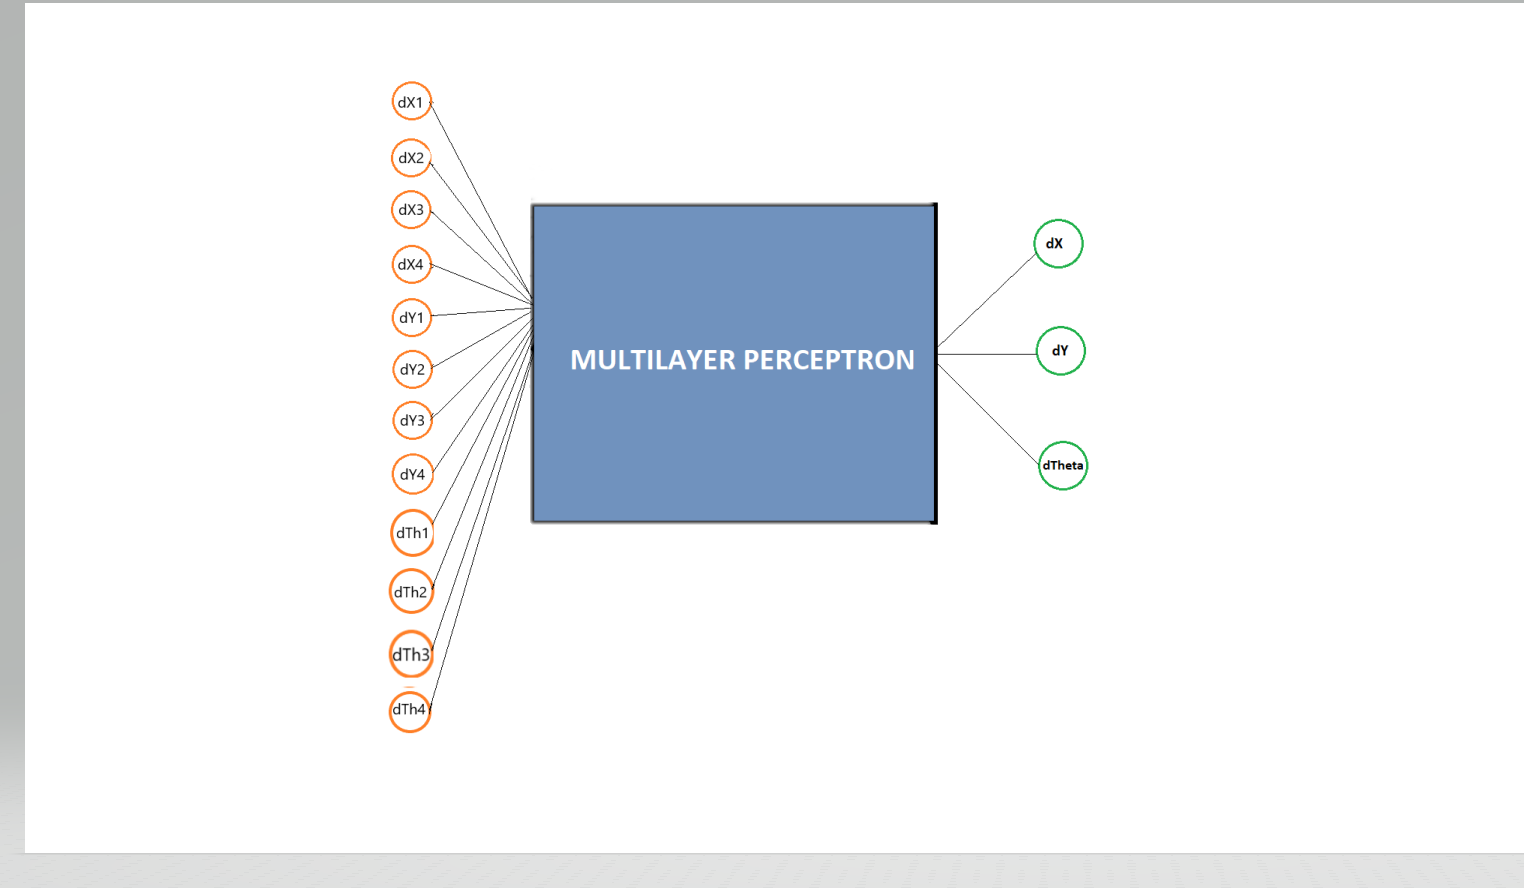

In [1]:
import cv2
import glob
import pickle
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
skip_training = False

In [3]:
device = torch.device('cpu')
#device = torch.device('cuda:0')

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/My Drive/Alive_Reckoning")
!ls

Mounted at /content/drive
1_mlp_pytorch.ipynb			  foo.pdf
Alive_Reckoning_manual_GroundTruth.ipynb  GMouse_Win_UsersGuide-V11.pdf
Alive_Reckoning_manual_prediction.ipynb   Images
AliveReckoning_MLP			  particle_filter_mean_1000.txt
Alive-Reckoning_mlp.ipynb		  particle_filter_mean.txt
DR					  robot4_motors.txt
DR_1000					  robot4_reference.txt


In [5]:
#Read the data and store it in array

val = []
with open('robot4_reference.txt') as f:
  for i in range(278):
    lines = f.readline()
    lines = lines.split()
    val.append(lines[1:])


In [6]:
print(val)

[['378', '1850', '1897'], ['494', '1853', '1897'], ['699', '1853', '1897'], ['986', '1850', '1897'], ['1091', '1853', '1897'], ['1365', '1850', '1897'], ['1499', '1853', '1897'], ['1615', '1850', '1897'], ['1993', '1850', '1897'], ['2115', '1850', '1897'], ['2354', '1853', '1897'], ['2585', '1853', '1897'], ['2797', '1853', '1897'], ['2890', '1850', '1897'], ['3155', '1814', '1874'], ['3359', '1768', '1842'], ['3580', '1740', '1821'], ['3725', '1726', '1812'], ['3941', '1695', '1792'], ['4191', '1650', '1763'], ['4307', '1633', '1751'], ['4533', '1603', '1730'], ['4785', '1555', '1701'], ['4990', '1527', '1684'], ['5103', '1513', '1672'], ['5371', '1479', '1652'], ['5517', '1446', '1631'], ['5762', '1415', '1611'], ['5955', '1370', '1582'], ['6067', '1353', '1570'], ['6394', '1325', '1550'], ['6510', '1295', '1530'], ['6744', '1261', '1509'], ['6974', '1217', '1480'], ['7110', '1203', '1472'], ['7344', '1172', '1451'], ['7581', '1125', '1422'], ['7786', '1094', '1402'], ['7905', '1078'

In [7]:
#Convert stored data from string to integer

for j in range(278):
  for k in range(3):
    val[j][k] = float(val[j][k])

In [8]:
print(val[1][1] - val[0][1])

3.0


In [9]:
#Create an array of delta X, delta Y, delta Theta

delta = np.zeros_like(val)

for i in range(277):
  for j in range(2):
    delta[i][j] = val[i+1][j+1] - val[i][j+1]
  num = val[i+1][2]-val[i][2]
  den = val[i+1][1]-val[i][1]
  delta[i][2] = np.arctan2(num, den, dtype = float)
  #print(den)





In [10]:
np.arctan2(0,-3)

3.141592653589793

In [11]:
print(delta) #delta_x||delta_y||delta_theta


[[ 3.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.00000000e+00  0.00000000e+00  3.14159265e+00]
 [ 3.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.00000000e+00  0.00000000e+00  3.14159265e+00]
 [ 3.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.00000000e+00  0.00000000e+00  3.14159265e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.00000000e+00  0.00000000e+00  3.14159265e+00]
 [-3.60000000e+01 -2.30000000e+01 -2.57306811e+00]
 [-4.60000000e+01 -3.20000000e+01 -2.53379066e+00]
 [-2.80000000e+01 -2.10000000e+01 -2.49809154e+00]
 [-1.40000000e+01 -9.00000000e+00 -2.57025517e+00]
 [-3.10000000e+01 -2.00000000e+01 -2.56862651e+00]
 [-4.50000000e+01 -2.90000000e+01 -2.56913284e+00]
 [-1.70000000e+01 -1.20000000e+

In [12]:
print(np.concatenate((delta[1], delta[2]), axis = 0))

[ 0.          0.          0.         -3.          0.          3.14159265]


In [13]:
#Create Input and Output list

input = np.zeros((54, 12))
target = np.zeros((54, 3))

for i in range(54):
  input[i] = np.concatenate((delta[5*i], delta[5*i+1], delta[5*i+2], delta[5*i+3]), axis = 0)
  target[i] = delta[5*i + 4]

#Scaling  
target[:,0] = target[:,0]/100
target[:,1] = target[:,1]/100
target[:,2] = target[:,2]/10





In [14]:
print(input.shape)

(54, 12)


In [15]:
print(target.shape)

(54, 3)


In [16]:
#Split in training and testing dataset
#50% training
#50% testing

train_inp = input[0:30]
train_target = target[0:30]
test_inp = input[30:-1]
test_target = target[30:-1]


In [17]:
print(train_inp)

[[ 3.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.00000000e+00  0.00000000e+00
   3.14159265e+00  3.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.00000000e+00  0.00000000e+00  0.00000000e+00 -3.00000000e+00
   0.00000000e+00  3.14159265e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.00000000e+00  0.00000000e+00
   3.14159265e+00 -3.60000000e+01 -2.30000000e+01 -2.57306811e+00]
 [-2.80000000e+01 -2.10000000e+01 -2.49809154e+00 -1.40000000e+01
  -9.00000000e+00 -2.57025517e+00 -3.10000000e+01 -2.00000000e+01
  -2.56862651e+00 -4.50000000e+01 -2.90000000e+01 -2.56913284e+00]
 [-3.00000000e+01 -2.10000000e+01 -2.53086669e+00 -4.80000000e+01
  -2.90000000e+01 -2.59811506e+00 -2.80000000e+01 -1.70000000e+01
  -2.59593760e+00 -1.40000000e+01 -1.20000000e+01 -2.43296638e+00]
 [-3.

In [18]:
print(train_target)

[[-0.03        0.          0.31415927]
 [ 0.03        0.          0.        ]
 [-0.46       -0.32       -0.25337907]
 [-0.17       -0.12       -0.25269297]
 [-0.34       -0.2        -0.26098686]
 [-0.28       -0.2        -0.25213432]
 [-0.31       -0.21       -0.25461828]
 [-0.44       -0.29       -0.25588532]
 [-0.33       -0.2        -0.25967287]
 [-0.19       -0.09       -0.26992184]
 [-0.46       -0.29       -0.25790947]
 [-0.33       -0.17       -0.26658974]
 [-0.33       -0.4        -0.22605964]
 [-0.06       -0.17       -0.19100889]
 [ 0.06       -0.52       -0.14559197]
 [ 0.08       -0.11       -0.0942    ]
 [ 0.17       -0.08       -0.04398426]
 [ 0.17        0.          0.        ]
 [ 0.2         0.          0.        ]
 [ 0.39        0.          0.        ]
 [ 0.36        0.          0.        ]
 [ 0.36        0.05        0.0138006 ]
 [ 0.27        0.22        0.06837093]
 [ 0.05        0.17        0.12847449]
 [-0.06        0.17        0.19100889]
 [-0.14        0.08      

In [19]:
Input_train, Target_train = shuffle(train_inp, train_target, random_state=0)

In [20]:
print(Input_train)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.00000000e+00  0.00000000e+00
   3.14159265e+00 -3.60000000e+01 -2.30000000e+01 -2.57306811e+00]
 [-1.40000000e+01  1.40000000e+01  2.35619449e+00 -4.40000000e+01
   3.40000000e+01  2.48370405e+00 -2.80000000e+01  2.20000000e+01
   2.47562342e+00 -3.10000000e+01  2.50000000e+01  2.46293016e+00]
 [-1.00000000e+01 -1.70000000e+01 -2.10252039e+00 -1.90000000e+01
  -2.80000000e+01 -2.16699547e+00 -2.20000000e+01 -5.30000000e+01
  -1.96424696e+00 -1.30000000e+01 -3.40000000e+01 -1.93599778e+00]
 [-4.40000000e+01 -2.90000000e+01 -2.55885316e+00 -3.00000000e+01
  -2.00000000e+01 -2.55359005e+00 -5.00000000e+01 -2.80000000e+01
  -2.63110433e+00 -1.40000000e+01 -9.00000000e+00 -2.57025517e+00]
 [-3.40000000e+01  3.10000000e+01  2.40231561e+00 -3.00000000e+01
   2.20000000e+01  2.50884382e+00 -3.10000000e+01  2.20000000e+01
   2.52440126e+00 -4.40000000e+01  3.60000000e+01  2.45586314e+00]
 [ 1.

In [21]:
print(Target_train)

[[-0.46       -0.32       -0.25337907]
 [-0.3         0.22        0.25088438]
 [-0.06       -0.17       -0.19100889]
 [-0.46       -0.29       -0.25790947]
 [-0.14        0.11        0.24756234]
 [-0.06        0.17        0.19100889]
 [-0.47        0.33        0.25294402]
 [-0.33       -0.17       -0.26658974]
 [ 0.17        0.          0.        ]
 [ 0.27        0.22        0.06837093]
 [-0.28       -0.2        -0.25213432]
 [ 0.17       -0.08       -0.04398426]
 [-0.33       -0.2        -0.25967287]
 [ 0.06       -0.52       -0.14559197]
 [ 0.05        0.17        0.12847449]
 [ 0.36        0.          0.        ]
 [ 0.03        0.          0.        ]
 [-0.31        0.19        0.25917395]
 [-0.31       -0.21       -0.25461828]
 [-0.34       -0.2        -0.26098686]
 [ 0.2         0.          0.        ]
 [ 0.39        0.          0.        ]
 [-0.19       -0.09       -0.26992184]
 [-0.44       -0.29       -0.25588532]
 [-0.14        0.08        0.26224465]
 [-0.17       -0.12      

In [22]:
Input_train = torch.tensor(np.array(Input_train))
Target_train = torch.tensor(np.array(Target_train))
Input_train = Input_train.to(torch.double)
Target_train = Target_train.to(torch.double)

In [23]:
Input_test = torch.tensor(np.array(test_inp))
Target_test = torch.tensor(np.array(test_target))
Input_test = Input_test.to(torch.double)
Target_test = Target_test.to(torch.double)

In [24]:
print(Input_train.shape)
print(Target_train.shape)

torch.Size([30, 12])
torch.Size([30, 3])


In [25]:
Input_train = torch.reshape(Input_train, (Input_train.shape[0], 1, 1, Input_train.shape[1]))
Input_test = torch.reshape(Input_test, (Input_test.shape[0], 1, 1, Input_test.shape[1]))

Target_train = torch.reshape(Target_train, (Target_train.shape[0], 1, 1, Target_train.shape[1]))
Target_test = torch.reshape(Target_test, (Target_test.shape[0], 1, 1, Target_test.shape[1]))

In [26]:
Input_train = Input_train.to(device)
Input_test = Input_test.to(device)
Target_train_ = Target_train.to(device)
Target_test_ = Target_test.to(device)

In [27]:
Input_train = Input_train.to(torch.float)
Target_train = Target_train_.to(torch.float)
Input_test = Input_test.to(torch.float)
Target_test = Target_test_.to(torch.float)

In [28]:
print(Target_train.shape)
print(Target_train[:,0,0,0])

torch.Size([30, 1, 1, 3])
tensor([-0.4600, -0.3000, -0.0600, -0.4600, -0.1400, -0.0600, -0.4700, -0.3300,
         0.1700,  0.2700, -0.2800,  0.1700, -0.3300,  0.0600,  0.0500,  0.3600,
         0.0300, -0.3100, -0.3100, -0.3400,  0.2000,  0.3900, -0.1900, -0.4400,
        -0.1400, -0.1700, -0.0300,  0.3600,  0.0800, -0.3300])


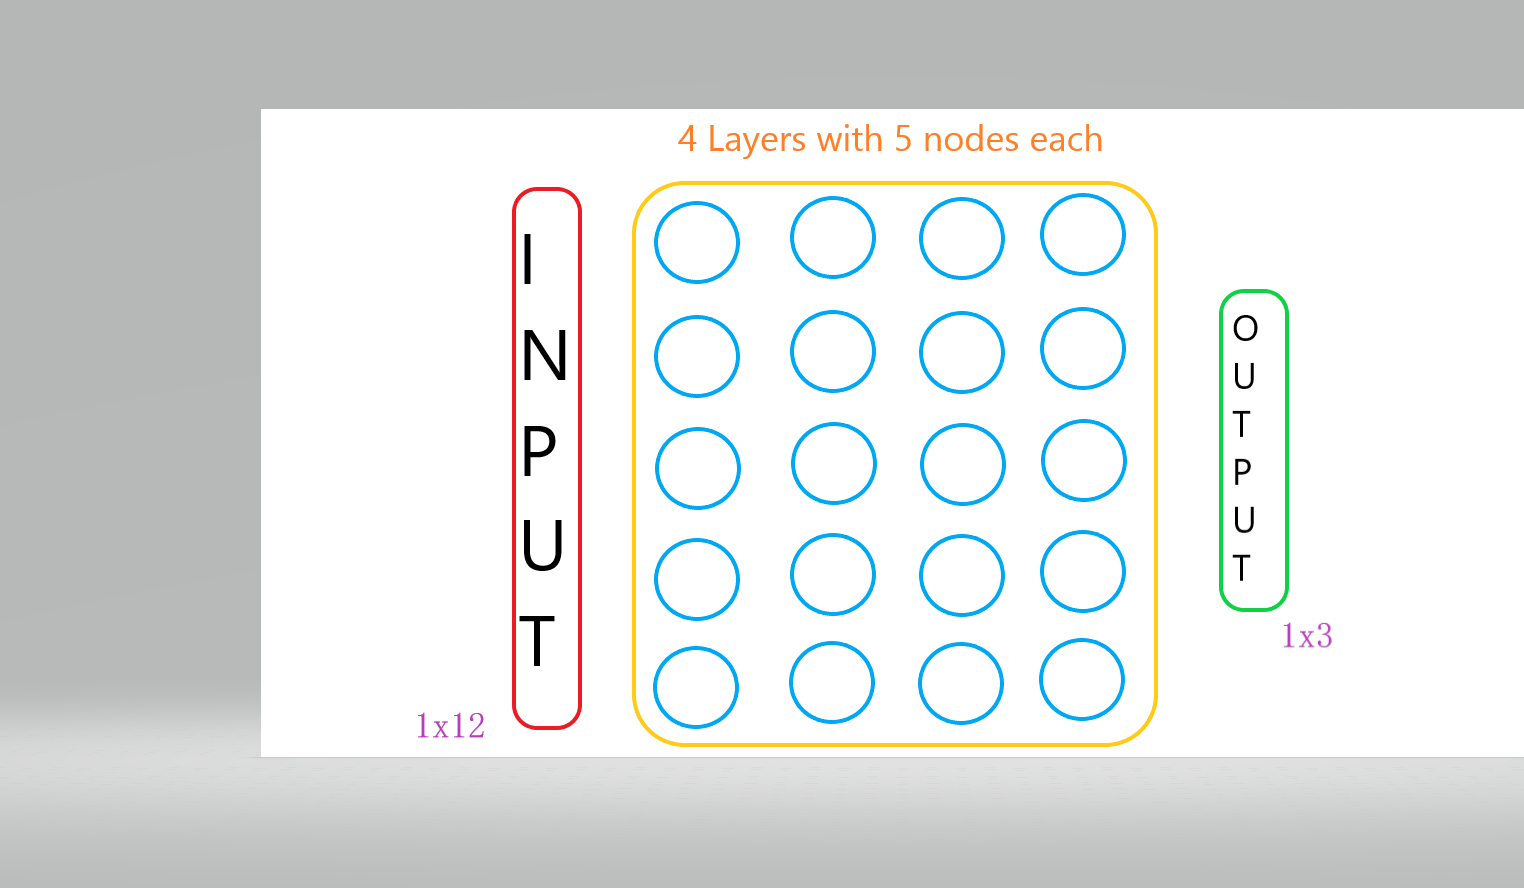

In [29]:
from numpy.core.numeric import zeros_like
class MLP(nn.Module):
    def __init__(self, n_inputs=12):
        # YOUR CODE HERE
        super(MLP,self).__init__()
        len = 20
        #10, 5, 15
        l2_size = len
        l3_size = len
        l4_size = len
        l5_size = len
        l6_size = len
        l7_size = len
        l8_size = len
        l9_size = 3
        
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(n_inputs,l2_size)
        self.l3 = nn.Linear(l2_size,l3_size)
        self.l4 = nn.Linear(l3_size,l4_size)
        self.l5 = nn.Linear(l4_size,l5_size)
        self.l6 = nn.Linear(l5_size,l6_size)
        self.l7 = nn.Linear(l6_size,l7_size)
        self.l8 = nn.Linear(l7_size,l8_size)
        self.l9 = nn.Linear(l8_size,l9_size)
        
        return None

        raise NotImplementedError()

    def forward(self, x):
        """
        Args:
          x of shape (n_samples, n_inputs): Model inputs.
        
        Returns:
          y of shape (n_samples, 1): Model outputs.
        """
       
        out = self.l2(x)
        out = self.tanh(out)
        out = self.l3(out)
        out = self.tanh(out)
        out = self.l4(out)
        out = self.tanh(out)
        out = self.l5(out)
        out = self.tanh(out)
        out = self.l6(out)
        out = self.tanh(out)
        out = self.l7(out)
        out = self.tanh(out)
        out = self.l8(out)
        out = self.tanh(out)
        out = self.l9(out)
        out = self.tanh(out)

                
        return out
       
        #raise NotImplementedError()

In [30]:
print(Input_train[0])

tensor([[[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -3.0000,
            0.0000,   3.1416, -36.0000, -23.0000,  -2.5731]]])


In [31]:
m = MLP()
m = m.float()
m.to(device)


MLP(
  (tanh): Tanh()
  (l2): Linear(in_features=12, out_features=20, bias=True)
  (l3): Linear(in_features=20, out_features=20, bias=True)
  (l4): Linear(in_features=20, out_features=20, bias=True)
  (l5): Linear(in_features=20, out_features=20, bias=True)
  (l6): Linear(in_features=20, out_features=20, bias=True)
  (l7): Linear(in_features=20, out_features=20, bias=True)
  (l8): Linear(in_features=20, out_features=20, bias=True)
  (l9): Linear(in_features=20, out_features=3, bias=True)
)

In [32]:
k = m(Input_train[0:5])
print(k)
#print(Target_train[0:10].shape)

tensor([[[[-0.0826, -0.2181,  0.0616]]],


        [[[-0.0718, -0.2352,  0.0602]]],


        [[[-0.0801, -0.2185,  0.0651]]],


        [[[-0.0725, -0.2240,  0.0741]]],


        [[[-0.0756, -0.2271,  0.0579]]]], grad_fn=<TanhBackward0>)


In [33]:
#RMSE 

def RMSE(inp1, inp2):
  inp1 = torch.reshape(inp1, (inp1.shape[0], inp1.shape[3]))
  inp2 = torch.reshape(inp2, (inp2.shape[0], inp2.shape[3]))
  sq_err = (inp1 - inp2)**2
  sum_err = torch.sum(sq_err)
  mean_err = torch.sum(sum_err)/inp1.shape[0]
  rmse_err = torch.sqrt(mean_err)
  
  return rmse_err
  

In [34]:
#Training error

def train_err():

  m.eval()
  with torch.no_grad():
    out = m(Input_train)
    err = RMSE(out, Target_train)
    
  return err
    


In [35]:
#Testing error

def test_err():

  m.eval()
  with torch.no_grad():
    out = m(Input_test)
    err = RMSE(out, Target_test)
   
  return err



In [36]:
print(test_err())

tensor(0.4729)


In [37]:
if not skip_training:

    loss_list = []
    train_error_list = []
    test_error_list = []

    optimizer = optim.Adam(m.parameters(), lr=0.0001) 
    criterion = nn.MSELoss()
    step = 400
   
    for j in range(step):
      sum = 0
      for k in range(9):

        m.train()           
        optimizer.zero_grad()
        out = m(Input_train[3*k:3*k+3])

        loss = criterion(out,Target_train[3*k:3*k+3])
        loss.backward()
        optimizer.step()
        sum = sum + loss

      loss_ = sum/9
      print(loss_)
      loss_list.append(loss_)

      err_tr = train_err()
      print(err_tr)# training error
      train_error_list.append(err_tr)

      err_tst = test_err() 
      print(err_tst)# testing error
      test_error_list.append(err_tst)


tensor(0.0624, grad_fn=<DivBackward0>)
tensor(0.4259)
tensor(0.4685)
tensor(0.0604, grad_fn=<DivBackward0>)
tensor(0.4197)
tensor(0.4641)
tensor(0.0587, grad_fn=<DivBackward0>)
tensor(0.4139)
tensor(0.4600)
tensor(0.0570, grad_fn=<DivBackward0>)
tensor(0.4084)
tensor(0.4562)
tensor(0.0556, grad_fn=<DivBackward0>)
tensor(0.4034)
tensor(0.4526)
tensor(0.0542, grad_fn=<DivBackward0>)
tensor(0.3986)
tensor(0.4491)
tensor(0.0529, grad_fn=<DivBackward0>)
tensor(0.3941)
tensor(0.4458)
tensor(0.0517, grad_fn=<DivBackward0>)
tensor(0.3897)
tensor(0.4426)
tensor(0.0505, grad_fn=<DivBackward0>)
tensor(0.3856)
tensor(0.4395)
tensor(0.0494, grad_fn=<DivBackward0>)
tensor(0.3815)
tensor(0.4363)
tensor(0.0484, grad_fn=<DivBackward0>)
tensor(0.3774)
tensor(0.4332)
tensor(0.0473, grad_fn=<DivBackward0>)
tensor(0.3733)
tensor(0.4300)
tensor(0.0462, grad_fn=<DivBackward0>)
tensor(0.3690)
tensor(0.4267)
tensor(0.0451, grad_fn=<DivBackward0>)
tensor(0.3646)
tensor(0.4233)
tensor(0.0440, grad_fn=<DivBackwar

<function matplotlib.pyplot.show>

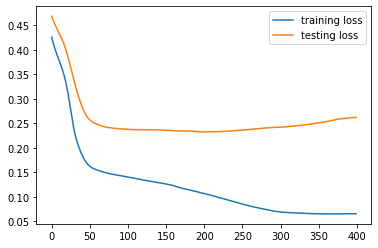

In [38]:
#Plot

x = range(len(train_error_list))
plt.plot(x, train_error_list, label = "training loss")
plt.plot(x, test_error_list, label = "testing loss")
plt.legend()
plt.show

In [39]:
#Save model
with open('AliveReckoning_MLP', 'wb') as g:
  pickle.dump(m, g)

In [40]:
#Training
m.eval()
with torch.no_grad():
  out = m(Input_train)
  print(out.shape)
  #print(RMSE(out, Target_train))
  out = torch.reshape(out, (out.shape[0], out.shape[3]))
  out[:,0] = out[:,0]*100
  out[:,1] = out[:,1]*100
  out[:,2] = out[:,2]*10

  Tgt_train = np.copy(Target_train)
  Tgt_train = torch.tensor(np.array(Tgt_train))
  Tgt_train = torch.reshape(Tgt_train, (Tgt_train.shape[0], Tgt_train.shape[3]))
  Tgt_train[:,0] = Tgt_train[:,0]*100
  Tgt_train[:,1] = Tgt_train[:,1]*100
  Tgt_train[:,2] = Tgt_train[:,2]*10

  print(out[0:5])
  print(Tgt_train[0:5])
  #print(Target_train[0:5])

torch.Size([30, 1, 1, 3])
tensor([[-46.3883, -30.8808,  -3.0546],
        [-29.9734,  22.4246,   2.4842],
        [ -5.9756, -17.0102,  -1.8712],
        [-46.1817, -30.2492,  -2.4262],
        [-13.8038,  10.2584,   2.3506]])
tensor([[-46.0000, -32.0000,  -2.5338],
        [-30.0000,  22.0000,   2.5088],
        [ -6.0000, -17.0000,  -1.9101],
        [-46.0000, -29.0000,  -2.5791],
        [-14.0000,  11.0000,   2.4756]])


In [41]:
#Testing
m.eval()
with torch.no_grad():
  out = m(Input_test)
  #print(RMSE(out, Target_test))
  out = torch.reshape(out, (out.shape[0], out.shape[3]))
  out[:,0] = out[:,0]*100
  out[:,1] = out[:,1]*100
  out[:,2] = out[:,2]*10
  print(out[0:5])

  
  Tgt_test = np.copy(Target_test)
  Tgt_test = torch.tensor(np.array(Tgt_test))
  Tgt_test = torch.reshape(Tgt_test, (Tgt_test.shape[0], Tgt_test.shape[3]))
  Tgt_test[:,0] = Tgt_test[:,0]*100
  Tgt_test[:,1] = Tgt_test[:,1]*100
  Tgt_test[:,2] = Tgt_test[:,2]*10
  print(Tgt_test[0:5])
  #print(Target_test[10:15])

tensor([[-36.2608, -23.5593,  -1.9334],
        [-16.7660,   0.0916,  -1.3297],
        [ 17.5913, -38.4136,  -1.1079],
        [  4.3361, -31.2863,  -1.0947],
        [-27.0035, -18.7483,  -2.1092]])
tensor([[-13.0000,  -5.0000,  -2.7744],
        [ -5.0000, -11.0000,  -1.9974],
        [  9.0000, -25.0000,  -1.2252],
        [ 11.0000, -36.0000,  -1.2743],
        [  5.0000, -16.0000,  -1.2679]])


In [42]:
def mlp_out_cor(prev_data, DR):

  updt_cor = np.zeros((1,3))
  m.eval()
  with torch.no_grad():
    DR_ = np.copy(DR)
    input = torch.tensor(np.array(prev_data))
    #print(input.shape)
    input = torch.reshape(input, (1, 1, 1, input.shape[0]))
    input = input.to(device)
    input = input.to(torch.float)

    out = m(input)
    #print(out.shape)
    out = torch.reshape(out, (out.shape[0], out.shape[3]))

    out[:,0] = out[:,0]*100
    out[:,1] = out[:,1]*100
    out[:,2] = out[:,2]*10

    # updt_cor[0][0] = out[0][0] + DR_[0][0]
    # updt_cor[0][1] = out[0][1] + DR_[0][1]
    # updt_cor[0][2] = out[0][2] + DR_[0][2]

    updt_cor[0][0] = out[0][0] + DR_[0]
    updt_cor[0][1] = out[0][1] + DR_[1]
    #updt_cor[0][2] = out[0][2] + DR_[2]

  return updt_cor

Running MLP on Real time data


In [43]:
with open('DR', 'rb') as g:
  DR = pickle.load(g)

In [44]:
DR[4]

[1757.0, 1895.0, -2.48]

In [45]:
def Real_out(base):

  delta_AR = np.zeros((4,3))
  weight = 1
  AR_MLP = np.copy(base)

  for k in range(len(base)-5):
    for i in range(4):
      for j in range(2):
        delta_AR[i][j] = base[k+i+1][j] - base[k+i][j]

      num = base[k+i+1][1]-base[k+i][1]
      den = base[k+i+1][0]-base[k+i][0]
      delta_AR[i][2] = np.arctan2(num, den, dtype = float)

    inp = np.concatenate((delta_AR[0], delta_AR[1], delta_AR[2], delta_AR[3]), axis = 0) 
    #print(inp)
    cor_out = mlp_out_cor(inp, base[k+4])
    #print(cor_out)
    #print(DR[k+5])
    x_updt = (base[k+5][0]*weight + cor_out[0][0])/(weight+1)
    y_updt = (base[k+5][1]*weight + cor_out[0][1])/(weight+1)
    AR_MLP[k+5][0] = x_updt
    AR_MLP[k+5][1] = y_updt

    #print(x_updt)
    #print(y_updt)

  return AR_MLP


In [46]:
AR_MLP_ = Real_out(DR)

In [47]:
print(AR_MLP_)

[[ 1.77300000e+03  1.87800000e+03 -2.49900000e+00]
 [ 1.76700000e+03  1.87800000e+03 -2.49500000e+00]
 [ 1.76400000e+03  1.88800000e+03 -2.48800000e+00]
 [ 1.75900000e+03  1.89300000e+03 -2.48200000e+00]
 [ 1.75700000e+03  1.89500000e+03 -2.48000000e+00]
 [ 1.75225018e+03  1.90761163e+03 -2.47600000e+00]
 [ 1.74442682e+03  1.91145697e+03 -2.47400000e+00]
 [ 1.74355927e+03  1.91449023e+03 -2.47500000e+00]
 [ 1.74837512e+03  1.91561469e+03 -2.47400000e+00]
 [ 1.75338751e+03  1.89514417e+03 -2.47400000e+00]
 [ 1.75945416e+03  1.89260547e+03 -2.47400000e+00]
 [ 1.75342603e+03  1.89682928e+03 -2.47400000e+00]
 [ 1.76284650e+03  1.90082446e+03 -2.47400000e+00]
 [ 1.74607312e+03  1.89259161e+03 -2.49100000e+00]
 [ 1.69470490e+03  1.86714160e+03 -2.50000000e+00]
 [ 1.66874573e+03  1.84248395e+03 -2.49900000e+00]
 [ 1.64689734e+03  1.82708472e+03 -2.48900000e+00]
 [ 1.64669525e+03  1.81775079e+03 -2.49000000e+00]
 [ 1.62177747e+03  1.79083948e+03 -2.50000000e+00]
 [ 1.59053052e+03  1.77335876e+

In [48]:
print(DR)

[[1773.0, 1878.0, -2.499], [1767.0, 1878.0, -2.495], [1764.0, 1888.0, -2.488], [1759.0, 1893.0, -2.482], [1757.0, 1895.0, -2.48], [1755.0, 1900.0, -2.476], [1754.0, 1899.0, -2.474], [1755.0, 1899.0, -2.475], [1754.0, 1899.0, -2.474], [1754.0, 1899.0, -2.474], [1754.0, 1899.0, -2.474], [1754.0, 1899.0, -2.474], [1754.0, 1899.0, -2.474], [1735.0, 1885.0, -2.491], [1706.0, 1864.0, -2.5], [1682.0, 1846.0, -2.499], [1654.0, 1825.0, -2.489], [1654.0, 1825.0, -2.49], [1619.0, 1799.0, -2.5], [1586.0, 1776.0, -2.504], [1559.0, 1755.0, -2.502], [1534.0, 1736.0, -2.512], [1533.0, 1736.0, -2.512], [1494.0, 1707.0, -2.509], [1456.0, 1680.0, -2.51], [1459.0, 1682.0, -2.523], [1418.0, 1653.0, -2.525], [1392.0, 1636.0, -2.549], [1366.0, 1619.0, -2.549], [1331.0, 1594.0, -2.541], [1298.0, 1571.0, -2.529], [1295.0, 1569.0, -2.533], [1252.0, 1539.0, -2.538], [1208.0, 1507.0, -2.53], [1167.0, 1478.0, -2.53], [1169.0, 1479.0, -2.535], [1146.0, 1465.0, -2.541], [1114.0, 1443.0, -2.541], [1090.0, 1427.0, -2.

In [49]:
#Read the data and store it in array (Ground Truth)

val_GT = []
with open('robot4_reference.txt') as f:
  for i in range(278):
    lines_GT = f.readline()
    lines_GT = lines_GT.split()
    val_GT.append(lines_GT[1:])

In [50]:
#Convert stored data from string to integer

for j in range(278):
  for k in range(3):
    val_GT[j][k] = int(val_GT[j][k])

In [51]:
print(val_GT)

[[378, 1850, 1897], [494, 1853, 1897], [699, 1853, 1897], [986, 1850, 1897], [1091, 1853, 1897], [1365, 1850, 1897], [1499, 1853, 1897], [1615, 1850, 1897], [1993, 1850, 1897], [2115, 1850, 1897], [2354, 1853, 1897], [2585, 1853, 1897], [2797, 1853, 1897], [2890, 1850, 1897], [3155, 1814, 1874], [3359, 1768, 1842], [3580, 1740, 1821], [3725, 1726, 1812], [3941, 1695, 1792], [4191, 1650, 1763], [4307, 1633, 1751], [4533, 1603, 1730], [4785, 1555, 1701], [4990, 1527, 1684], [5103, 1513, 1672], [5371, 1479, 1652], [5517, 1446, 1631], [5762, 1415, 1611], [5955, 1370, 1582], [6067, 1353, 1570], [6394, 1325, 1550], [6510, 1295, 1530], [6744, 1261, 1509], [6974, 1217, 1480], [7110, 1203, 1472], [7344, 1172, 1451], [7581, 1125, 1422], [7786, 1094, 1402], [7905, 1078, 1393], [8151, 1047, 1373], [8366, 1003, 1344], [8560, 972, 1324], [8683, 953, 1313], [8853, 936, 1304], [9120, 892, 1272], [9375, 859, 1252], [9514, 845, 1244], [9753, 798, 1215], [9869, 768, 1195], [10144, 737, 1175], [10262, 718

In [52]:
val_GT_ = np.zeros((278,2))
for j in range(278):
  for k in range(2):
    val_GT_[j][k] = int(val_GT[j][k+1])

In [53]:
print(val_GT_)

[[1850. 1897.]
 [1853. 1897.]
 [1853. 1897.]
 [1850. 1897.]
 [1853. 1897.]
 [1850. 1897.]
 [1853. 1897.]
 [1850. 1897.]
 [1850. 1897.]
 [1850. 1897.]
 [1853. 1897.]
 [1853. 1897.]
 [1853. 1897.]
 [1850. 1897.]
 [1814. 1874.]
 [1768. 1842.]
 [1740. 1821.]
 [1726. 1812.]
 [1695. 1792.]
 [1650. 1763.]
 [1633. 1751.]
 [1603. 1730.]
 [1555. 1701.]
 [1527. 1684.]
 [1513. 1672.]
 [1479. 1652.]
 [1446. 1631.]
 [1415. 1611.]
 [1370. 1582.]
 [1353. 1570.]
 [1325. 1550.]
 [1295. 1530.]
 [1261. 1509.]
 [1217. 1480.]
 [1203. 1472.]
 [1172. 1451.]
 [1125. 1422.]
 [1094. 1402.]
 [1078. 1393.]
 [1047. 1373.]
 [1003. 1344.]
 [ 972. 1324.]
 [ 953. 1313.]
 [ 936. 1304.]
 [ 892. 1272.]
 [ 859. 1252.]
 [ 845. 1244.]
 [ 798. 1215.]
 [ 768. 1195.]
 [ 737. 1175.]
 [ 718. 1166.]
 [ 674. 1137.]
 [ 644. 1117.]
 [ 594. 1089.]
 [ 580. 1080.]
 [ 534. 1051.]
 [ 517. 1043.]
 [ 487. 1023.]
 [ 440.  994.]
 [ 424.  983.]
 [ 391.  966.]
 [ 361.  946.]
 [ 334.  920.]
 [ 320.  909.]
 [ 282.  867.]
 [ 249.  827.]
 [ 239.  8

In [54]:
val_GT_1 = Real_out(val_GT_)

In [55]:
print(val_GT_1)

[[1850.         1897.        ]
 [1853.         1897.        ]
 [1853.         1897.        ]
 [1850.         1897.        ]
 [1853.         1897.        ]
 [1850.09381104 1897.1975708 ]
 [1857.23797607 1880.81408691]
 [1855.1583252  1901.91741943]
 [1857.82305908 1879.67224121]
 [1852.59503174 1894.19549561]
 [1852.90447998 1896.83874512]
 [1868.13262939 1903.50952148]
 [1866.38366699 1893.34191895]
 [1850.11224365 1891.64959717]
 [1828.61102295 1870.51464844]
 [1767.80584717 1842.55957031]
 [1728.7512207  1818.99499512]
 [1717.11291504 1811.27575684]
 [1691.75396729 1790.57629395]
 [1653.37280273 1764.23931885]
 [1631.92230225 1750.90625   ]
 [1604.81854248 1733.42388916]
 [1565.58258057 1705.8381958 ]
 [1530.77050781 1686.3059082 ]
 [1512.01812744 1670.35894775]
 [1479.34783936 1651.37237549]
 [1439.46221924 1627.55474854]
 [1416.52294922 1613.89630127]
 [1387.52862549 1588.78717041]
 [1351.93237305 1569.32110596]
 [1324.13580322 1550.34832764]
 [1296.5723877  1530.33551025]
 [1256.3

In [56]:
x_GT = []
y_GT = []
for i in val_GT:
  x_GT.append(i[1])
  y_GT.append(i[2])

In [57]:
x_GT_ = []
y_GT_ = []
for i in val_GT_1:
  x_GT_.append(i[0])
  y_GT_.append(i[1])

In [58]:
x_AR = []
y_AR = []
for i in AR_MLP_:
  x_AR.append(i[0])
  y_AR.append(i[1])

In [59]:
x_DR = []
y_DR = []
for i in DR:
  x_DR.append(i[0])
  y_DR.append(i[1])

<function matplotlib.pyplot.show>

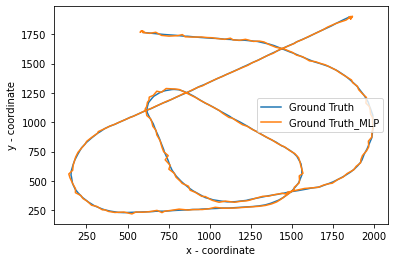

In [60]:
plt.plot(x_GT, y_GT, label = "Ground Truth")#Ground Truth
plt.plot(x_GT_, y_GT_, label = "Ground Truth_MLP")#Ground Truth
plt.xlabel('x - coordinate')
plt.ylabel('y - coordinate')
plt.legend()
plt.show

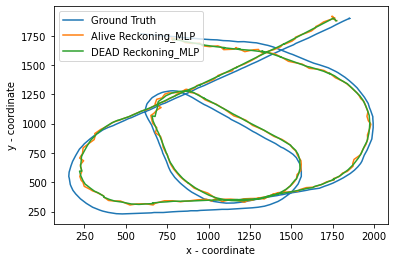

In [61]:
plt.plot(x_GT, y_GT, label = "Ground Truth")#Ground Truth
plt.plot(x_AR, y_AR, label = "Alive Reckoning_MLP")#Alive Reckoning
plt.plot(x_DR, y_DR, label = "DEAD Reckoning_MLP")#Dead Reckoning
plt.xlabel('x - coordinate')
plt.ylabel('y - coordinate')
plt.legend()
plt.show
plt.savefig('foo1.pdf')

In [62]:
def RMSE(inp1, inp2, inp3, inp4):
  inp1 = np.array(inp1)
  inp2 = np.array(inp2)
  inp3 = np.array(inp3)
  inp4 = np.array(inp4)
  rmse_err = np.mean(np.sqrt((inp1 - inp2)**2 + (inp3 - inp4)**2))
   
  return rmse_err

In [63]:
RMSE(x_GT, x_AR, y_GT, y_AR)

83.95551774392725

In [64]:
RMSE(x_GT, x_DR, y_GT, y_DR)

83.23155552581333